This notebook presents statistics of the book data integration.

## Setup


In [1]:
library(tidyverse, warn.conflicts=FALSE)
library(arrow, warn.conflicts=FALSE)
library(jsonlite)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     


── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors



Attaching package: ‘jsonlite’




The following object is masked from ‘package:purrr’:

    flatten




I want to use `theme_minimal()` by default:


In [2]:
theme_set(theme_minimal())

And default image sizes aren't great:


In [3]:
options(repr.plot.width  = 7,
        repr.plot.height = 4)

## Load Link Stats

We compute dataset linking statistics as `gender-stats.csv` as part of the integration.  Let's load those:


In [4]:
link_stats = read_csv("book-links/gender-stats.csv")
glimpse(link_stats)

Rows: 32 Columns: 4


── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): dataset, gender
dbl (2): n_books, n_actions



ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Rows: 32
Columns: 4
$ dataset   <chr> "LOC-MDS", "LOC-MDS", "LOC-MDS", "LOC-MDS", "LOC-MDS", "LOC-…
$ gender    <chr> "no-book-author", "female", "unknown", "male", "no-author-re…
$ n_books   <dbl> 597765, 738736, 1096259, 2418372, 305743, 74056, 247922, 245…
$ n_actions <dbl> NA, NA, NA, NA, NA, NA, 4910629, 929168, 2322219, 3840385, 2…


Now let's define variables for our variou codes. We are first going to define our gender codes.  We'll start with the resolved codes:


In [5]:
link_codes = c('female', 'male', 'ambiguous', 'unknown')

We want the unlink codes in order, so the last is the first link failure:


In [6]:
unlink_codes = c('no-author-rec', 'no-book-author', 'no-book')

In [7]:
all_codes = c(link_codes, unlink_codes)

## Processing Statistics

Now we'll pivot each of our count columns into a table for easier reference.


In [8]:
book_counts = link_stats %>%
    pivot_wider(id_cols=dataset, names_from=gender, values_from=n_books) %>%
    replace(is.na(.), 0) %>%
    mutate(total=rowSums(across(-dataset)))
glimpse(book_counts)

Rows: 5
Columns: 9
$ dataset          <chr> "LOC-MDS", "AZ14", "AZ18", "GR-I", "GR-E"
$ `no-book-author` <dbl> 597765, 166729, 151322, 744727, 732999
$ female           <dbl> 738736, 247922, 315367, 226472, 224202
$ unknown          <dbl> 1096259, 243557, 308882, 112988, 111058
$ male             <dbl> 2418372, 551096, 670536, 339186, 334900
$ `no-author-rec`  <dbl> 305743, 157739, 244385, 62489, 61381
$ ambiguous        <dbl> 74056, 24536, 28587, 19362, 19164
$ `no-book`        <dbl> 0, 865304, 1134492, 0, 0
$ total            <dbl> 5230931, 2256883, 2853571, 1505224, 1483704


In [9]:
act_counts = link_stats %>%
    filter(dataset != "LOC-MDS") %>%
    pivot_wider(id_cols=dataset, names_from=gender, values_from=n_actions) %>%
    replace(is.na(.), 0) %>%
    mutate(total=rowSums(across(-dataset)))
glimpse(act_counts)

Rows: 4
Columns: 9
$ dataset          <chr> "AZ14", "AZ18", "GR-I", "GR-E"
$ female           <dbl> 4910629, 12139969, 81089282, 35231444
$ ambiguous        <dbl> 929168, 2047757, 24011086, 14524429
$ `no-book-author` <dbl> 2322219, 2741320, 29430658, 11066998
$ `no-book`        <dbl> 3840385, 9857003, 0, 0
$ unknown          <dbl> 2212227, 4962852, 10749286, 3683791
$ male             <dbl> 7091138, 15541124, 69693611, 33048638
$ `no-author-rec`  <dbl> 1120824, 3365227, 3545950, 1031312
$ total            <dbl> 22426590, 50655252, 218519873, 98586612


We're going to want to compute versions of this table as fractions, e.g. the fraction of books that are written by women.  We will use the following helper function:


In [10]:
fractionalize = function(data, columns, unlinked=NULL) {
    fracs = select(data, dataset | all_of(columns))
    if (!is.null(unlinked)) {
        fracs = mutate(fracs, unlinked=rowSums(select(data, all_of(unlinked))))
    }
    totals = rowSums(select(fracs, !dataset))
    fracs %>% mutate(across(!dataset, ~ .x / totals))
}
fractionalize(book_counts, link_codes) %>% glimpse()

Rows: 5
Columns: 5
$ dataset   <chr> "LOC-MDS", "AZ14", "AZ18", "GR-I", "GR-E"
$ female    <dbl> 0.1707104, 0.2323301, 0.2383056, 0.3244547, 0.3252491
$ male      <dbl> 0.5588481, 0.5164374, 0.5066875, 0.4859343, 0.4858383
$ ambiguous <dbl> 0.01711319, 0.02299292, 0.02160164, 0.02773894, 0.02780115
$ unknown   <dbl> 0.2533284, 0.2282396, 0.2334053, 0.1618721, 0.1611115


And a helper function for plotting bar charts:


In [11]:
plot_bars = function(data, what="UNSPECIFIED") {
    tall = data %>%
        pivot_longer(!dataset, names_to="status", values_to="fraction")
    codes = c(all_codes, "unlinked")
    codes = intersect(codes, unique(tall$status))
    tall = tall %>% mutate(status=ordered(status, codes))
    ggplot(tall) +
        aes(y=dataset, x=fraction, fill=status) +
        geom_col(position=position_stack(reverse=TRUE), width=0.5) +
        geom_text(aes(label=if_else(fraction >= 0.1,
                                    sprintf("%.1f%%", fraction * 100),
                                    "")),
                  position=position_stack(reverse=TRUE, vjust=0.5),
                  colour="white", fontface="bold") +
        scale_fill_brewer(type="qual", palette="Dark2") +
        ylab("Dataset") +
        xlab(paste("Fraction of", what)) +
        labs(fill="Author Gender")
}

## Resolution of Books

What fraction of *unique books* are resolved from each source?


In [12]:
book_counts %>% fractionalize(all_codes)

dataset,female,male,ambiguous,unknown,no-author-rec,no-book-author,no-book
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
LOC-MDS,0.1412246,0.4623215,0.01415733,0.20957245,0.05844906,0.11427507,0.0000000
AZ14,0.1098515,0.2441846,0.01087163,0.10791742,0.06989241,0.07387578,0.3834067
AZ18,0.1105166,0.2349814,0.01001797,0.10824402,0.08564182,0.05302899,0.3975692
GR-I,0.1504573,0.2253392,0.01286320,0.07506391,0.04151475,0.49476158,0.0000000
GR-E,0.1511097,0.2257189,0.01291632,0.07485186,0.04137011,0.49403318,0.0000000


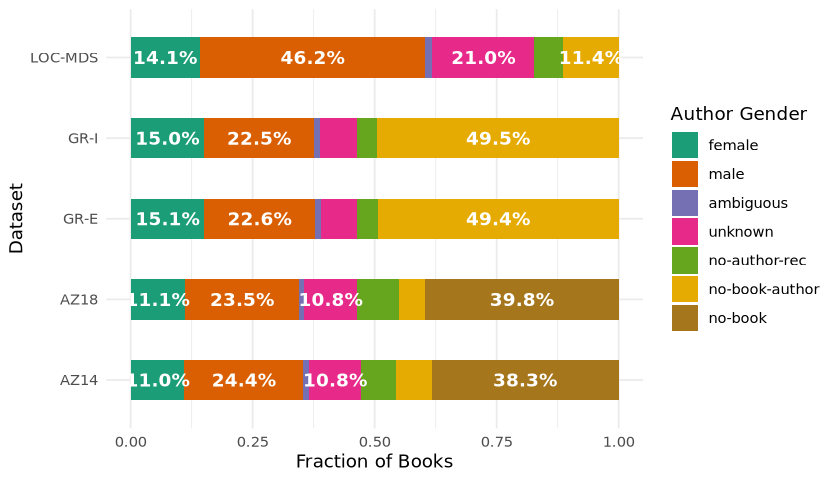

In [13]:
book_counts %>% fractionalize(all_codes) %>% plot_bars("Books")

In [14]:
book_counts %>% fractionalize(link_codes, unlink_codes)

dataset,female,male,ambiguous,unknown,unlinked
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
LOC-MDS,0.1412246,0.4623215,0.01415733,0.20957245,0.1727241
AZ14,0.1098515,0.2441846,0.01087163,0.10791742,0.5271749
AZ18,0.1105166,0.2349814,0.01001797,0.10824402,0.5362400
GR-I,0.1504573,0.2253392,0.01286320,0.07506391,0.5362763
GR-E,0.1511097,0.2257189,0.01291632,0.07485186,0.5354033


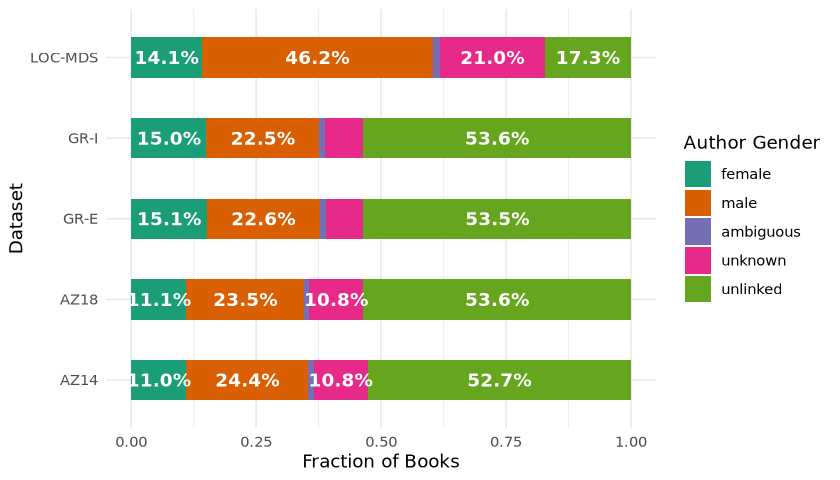

In [15]:
book_counts %>% fractionalize(link_codes, unlink_codes) %>% plot_bars("Books")

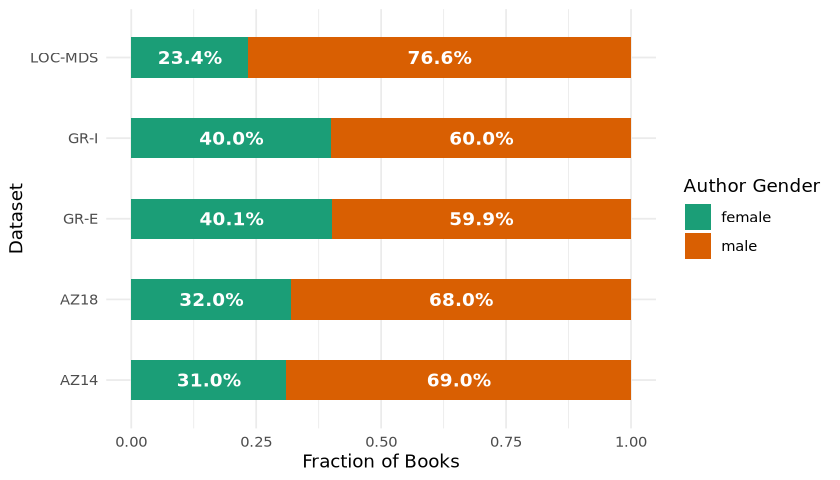

In [16]:
book_counts %>% fractionalize(c('female', 'male')) %>% plot_bars("Books")

## Resolution of Ratings

What fraction of *rating actions* have each resolution result?


In [17]:
act_counts %>% fractionalize(all_codes)

dataset,female,male,ambiguous,unknown,no-author-rec,no-book-author,no-book
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AZ14,0.2189646,0.3161933,0.04143153,0.09864304,0.04997746,0.10354757,0.1712425
AZ18,0.2396586,0.3068018,0.04042536,0.09797310,0.06643392,0.05411719,0.1945900
GR-I,0.3710842,0.3189349,0.10988056,0.04919134,0.01622713,0.13468184,0.0000000
GR-E,0.3573654,0.3352244,0.14732659,0.03736604,0.01046097,0.11225660,0.0000000


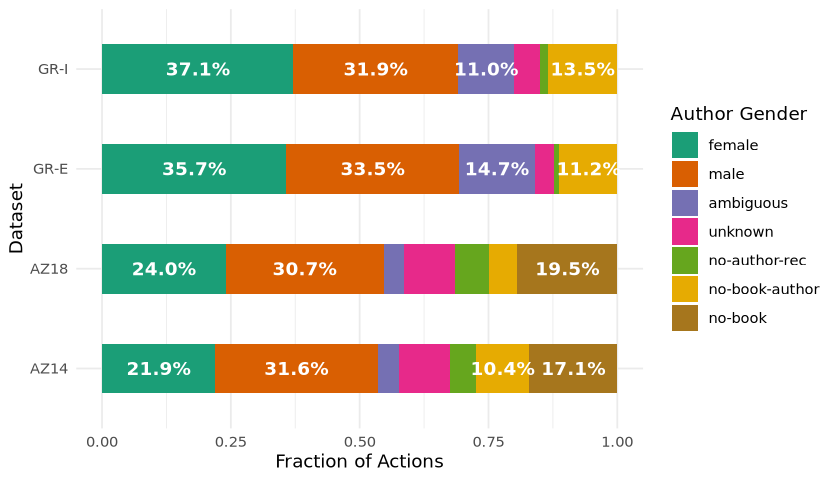

In [18]:
act_counts %>% fractionalize(all_codes) %>% plot_bars("Actions")

In [19]:
act_counts %>% fractionalize(link_codes, unlink_codes)

dataset,female,male,ambiguous,unknown,unlinked
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AZ14,0.2189646,0.3161933,0.04143153,0.09864304,0.3247675
AZ18,0.2396586,0.3068018,0.04042536,0.09797310,0.3151411
GR-I,0.3710842,0.3189349,0.10988056,0.04919134,0.1509090
GR-E,0.3573654,0.3352244,0.14732659,0.03736604,0.1227176


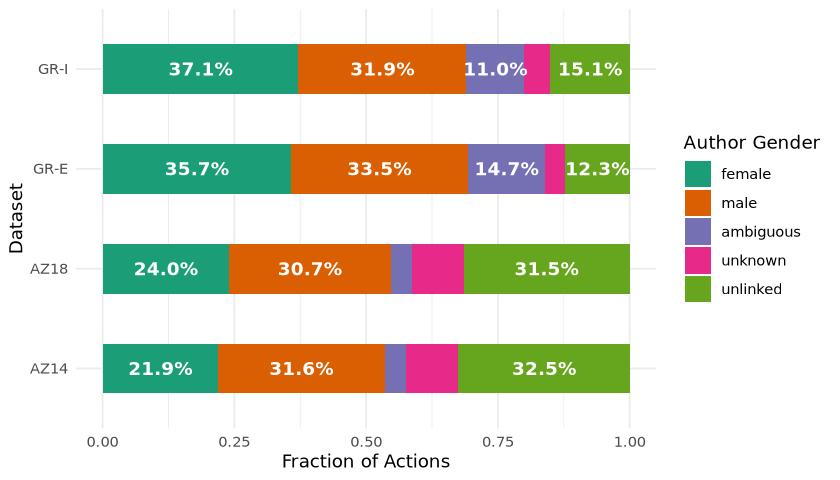

In [20]:
act_counts %>% fractionalize(link_codes, unlink_codes) %>% plot_bars("Actions")

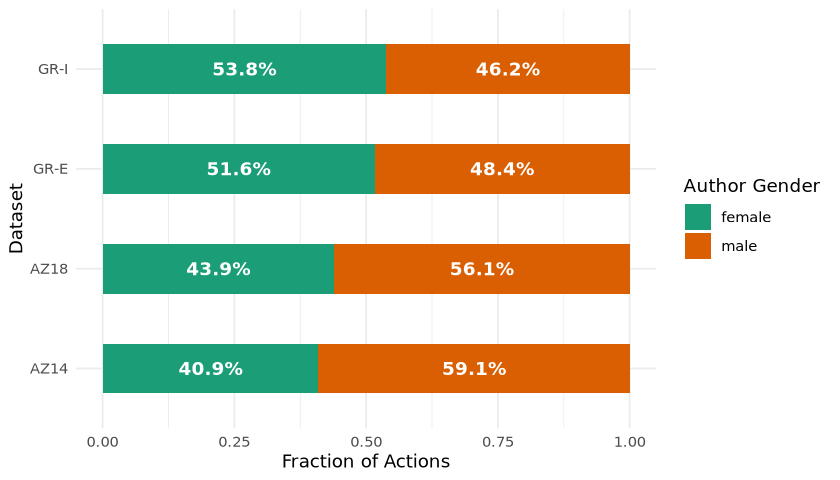

In [21]:
act_counts %>% fractionalize(c('female', 'male')) %>% plot_bars("Actions")

## Metrics

Finally, we're going to write coverage metrics.


In [22]:
book_linked = eval(quote(male + female + ambiguous), envir=book_counts)
book_coverage = book_linked / book_counts$total
book_coverage = setNames(book_coverage, book_counts$dataset)
book_coverage

LOC-MDS      AZ14      AZ18      GR-I      GR-E 
0.6177034 0.3649077 0.3555159 0.3886598 0.3897449

In [23]:
json = toJSON(
    as.list(book_coverage),
    auto_unbox=TRUE,
)
write_file(json, "book-coverage.json")